In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, os, logging, json, random, wandb, shap
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

In [2]:
path = '/data/jlai/ntups/csv/jet_faking_BDT_input_basic3.csv'
df = pd.read_csv(path)
df.describe()

,balance,VertexBDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,metsigres,met,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,mt,weights,label
count,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,-1.745489e+02,1.251438e-01,-1.663472e+03,-4.654471e+02,-1.848742e+02,4.027364e-01,2.738863e+00,-1.317202e+02,-1.313245e+02,-1.842713e+02,...,2.709180e+04,1.947991e+05,1.931356e+05,8.173447e+05,8.082155e+03,9.400769e+03,1.752871e+00,5.145135e+02,6.037499e-01,1.390112e-03
std,3.835393e+02,1.348625e-01,1.103691e+04,4.990919e+02,3.894295e+02,6.314438e-01,6.313107e-01,3.400961e+02,3.402509e+02,3.897176e+02,...,2.307818e+04,1.623949e+05,1.632818e+05,8.139494e+05,1.485037e+04,5.880428e+03,1.232225e+00,3.809920e+02,7.646898e+00,3.725829e-02
min,-9.990000e+02,-3.265468e-01,-1.712589e+05,-9.990000e+02,-9.990000e+02,0.000000e+00,1.167295e-02,-9.990000e+02,-9.990000e+02,-9.990000e+02,...,8.526343e+03,1.000000e+05,2.001940e+03,1.500329e+05,-9.990000e+02,0.000000e+00,0.000000e+00,1.000004e+02,-9.143369e+01,0.000000e+00
25%,9.546858e-01,8.068899e-03,0.000000e+00,-9.990000e+02,4.369926e-02,5.094965e-02,2.728096e+00,2.204334e-01,5.477069e-01,3.878704e-01,...,1.057160e+04,1.177408e+05,1.162434e+05,2.738635e+05,-9.990000e+02,4.993511e+03,1.000000e+00,2.392391e+02,1.026595e-04,0.000000e+00
50%,1.283851e+00,1.647640e-01,0.000000e+00,1.517193e-01,4.694079e-01,1.503438e-01,2.991172e+00,1.017702e+00,2.089735e+00,2.023582e+00,...,1.767059e+04,1.480967e+05,1.473863e+05,4.551331e+05,-9.990000e+02,8.329055e+03,2.000000e+00,3.804795e+02,1.174600e-02,0.000000e+00
75%,2.922425e+00,2.371679e-01,0.000000e+00,1.378248e+00,2.476912e+00,4.133940e-01,3.090613e+00,2.863652e+00,3.105098e+00,3.039348e+00,...,3.643209e+04,2.160463e+05,2.158321e+05,1.013744e+06,2.159741e+04,1.265224e+04,3.000000e+00,6.762628e+02,5.386639e-02,0.000000e+00
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141592e+00,...,6.173285e+06,1.470684e+08,1.470684e+08,1.490961e+08,5.999986e+04,1.022158e+05,4.000000e+00,7.007911e+03,1.221239e+04,1.000000e+00


In [3]:
Vars2 = ['dphi_met_phterm', 'metsig', 'VertexBDTScore', 'dphi_met_central_jet', 'dmet', 'jetterm', 'balance',  'weights', 'label', 'process']
Vars3 = ['ph_eta', 'ph_pt']

In [4]:
# === Data Perparation ===
df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()

df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

# Define X (features) and y (labels)
# Vars_drop = ['weights', 'label', 'process']
X = df_ml_input.drop(Vars_drop, axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']

random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

Number of event with negative weights : 218306


,dphi_met_phterm,metsig,VertexBDTScore,dphi_met_central_jet,dmet,jetterm,balance,weights,label,ph_eta,ph_pt
count,3.299733e+06,3.299733e+06,3.299733e+06,2.685312e+06,3.299732e+06,3.299733e+06,2.712769e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,4.027364e-01,1.190690e+01,1.251438e-01,1.404322e+00,-1.663472e+03,5.232991e+05,3.838187e+00,6.196378e-01,1.390112e-03,4.619389e+00,5.638744e-06
std,6.314438e-01,1.038910e+01,1.348625e-01,1.176454e+00,1.103691e+04,7.927709e+05,6.130255e+00,7.645627e+00,3.725829e-02,4.657088e+02,4.934680e-06
min,0.000000e+00,2.269695e-01,-3.265468e-01,1.192093e-07,-1.712589e+05,0.000000e+00,3.173358e-02,0.000000e+00,0.000000e+00,3.966429e-01,1.995369e-07
25%,5.094965e-02,3.802686e+00,8.068899e-03,1.804473e-01,0.000000e+00,3.469025e+04,1.127429e+00,1.428430e-03,0.000000e+00,7.511125e-01,1.213521e-06
50%,1.503438e-01,1.024574e+01,1.647640e-01,1.257375e+00,0.000000e+00,1.292316e+05,1.535997e+00,1.519263e-02,0.000000e+00,1.271312e+00,4.487454e-06
75%,4.133940e-01,1.590387e+01,2.371679e-01,2.651747e+00,0.000000e+00,6.824688e+05,3.771265e+00,6.219316e-02,0.000000e+00,2.644231e+00,8.563076e-06
max,3.141593e+00,2.823775e+02,4.375860e-01,3.141592e+00,1.246841e+05,5.019984e+06,2.663229e+02,1.221239e+04,1.000000e+00,8.314374e+05,1.999992e-05


Number of nan in each variable: 
dphi_met_phterm              0
metsig                       0
VertexBDTScore               0
dphi_met_central_jet    614421
dmet                         1
jetterm                      0
balance                 586964
weights                      0
label                        0
process                      0
ph_eta                       0
ph_pt                        0
dtype: int64
random number:  32


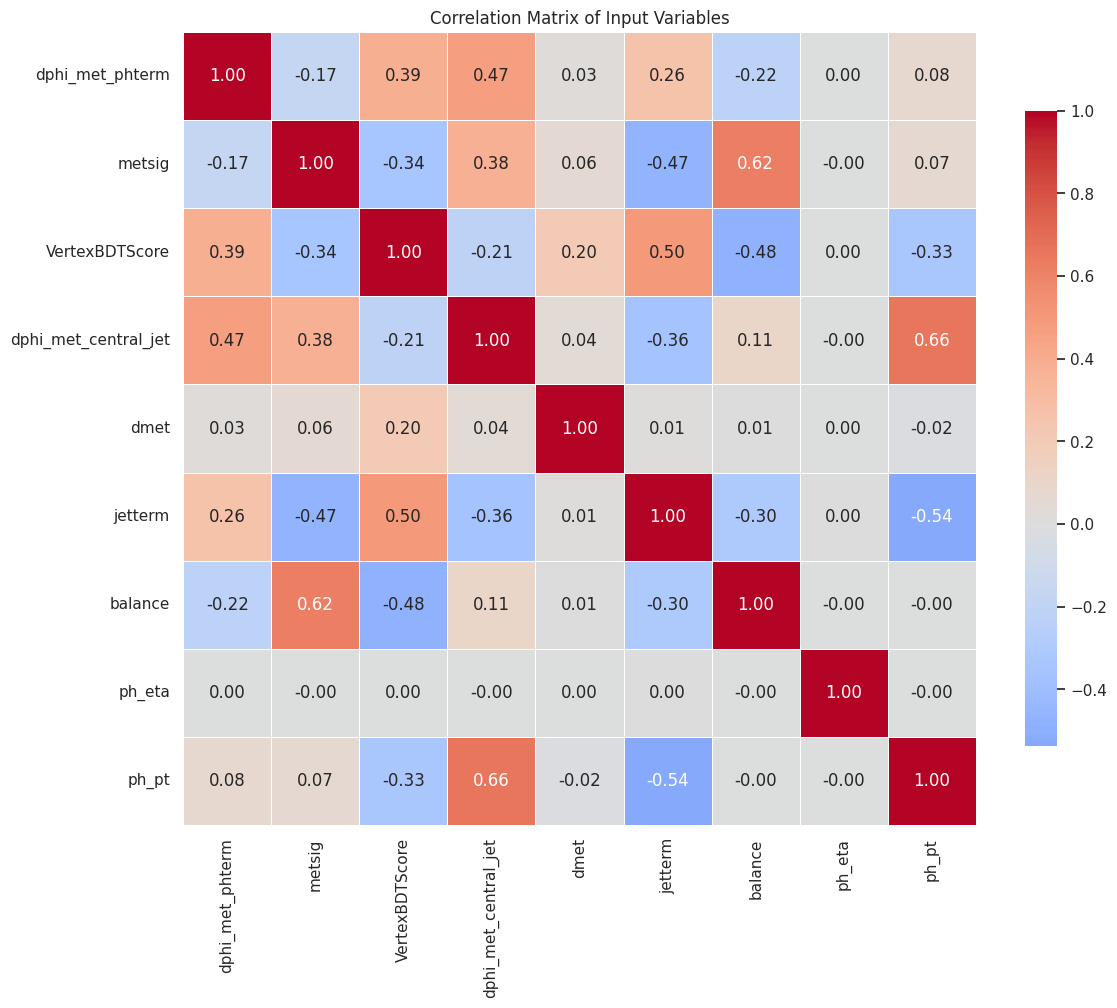

In [5]:
corr_features = df_ml_input.drop(Vars_drop, axis=1)
corr_matrix = corr_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Input Variables")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()


In [5]:
# === Sweep Config ===
sweep_config = {
    "method": "random", # "bayes" or "random"
    "metric": {"name": "Test ROC AUC", "goal": "maximize"},
    "parameters": {
        "max_depth": {"min": 3, "max": 10, "distribution": "int_uniform"},
        "learning_rate": {"min": 0.0001, "max": 0.1},
        "n_estimators": {"min": 100, "max": 900, "distribution": "int_uniform"},
        "subsample": {"min": 0.2, "max": 0.8},
        "gamma": {"min": 0.1, "max": 1.0}
    }
}
def compute_significance(df, score_column="bdtscore", cut=0.01):
    sig = df[(df["label"] == 1) & (df[score_column] >= cut)]["weights"].sum()
    bkg = df[(df["label"] == 0) & (df[score_column] >= cut)]["weights"].sum()
    return sig / np.sqrt(bkg) if bkg > 0 else 0, sig/df[(df["label"] == 1)]["weights"].sum()

def sweep_train():
    with wandb.init() as run:
        config = run.config

        model = XGBClassifier(
            tree_method='hist',
            device='cuda',
            max_depth=config.max_depth,
            learning_rate=config.learning_rate,
            n_estimators=config.n_estimators,
            subsample=config.subsample,
            gamma=config.gamma,
            early_stopping_rounds=10,
            eval_metric=['logloss', 'error', 'auc'],
            missing=np.nan,
            random_state=random_num
        )

        model.fit(
            X_train, y_train,
            sample_weight=sw_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            sample_weight_eval_set=[sw_train, sw_test],
            verbose=False
        )

        y_test_pred = model.predict_proba(X_test.to_numpy())[:, 1]
        test_auc = roc_auc_score(y_test, y_test_pred, sample_weight=sw_test)

        df_tmp = df_ml_input.copy()
        df_tmp["bdtscore2"] = model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]

        best_significance = 0
        best_acceptance = 0
        best_cut = 0
        for cut in np.arange(0, 0.15, 0.01):
            sig, acc = compute_significance(df_tmp, score_column="bdtscore2", cut=cut)
            if sig > best_significance:
                best_significance = sig
                best_acceptance = acc
                best_cut = cut

        wandb.log({
            "Test ROC AUC": test_auc,
            "Max S/sqrt(B)": best_significance,
            "Acceptance": best_acceptance,
            "bdtscore2 cut": best_cut
        })

        results = model.evals_result()
        train_loss = results['validation_0']['logloss']
        test_loss = results['validation_1']['logloss']

        for i, (train_l, test_l) in enumerate(zip(train_loss, test_loss)):
            wandb.log({
                "train_logloss": train_l,
                "test_logloss": test_l,
                "iteration": i
            })

In [6]:
# === Run Sweep ===
sweep_id = wandb.sweep(sweep_config, project="Dark_ph_BDT_Sweep_Reduced")
wandb.agent(sweep_id, function=sweep_train, count=30)

Create sweep with ID: woe18qc0
Sweep URL: https://wandb.ai/dlai211/Dark_ph_BDT_Sweep_Reduced/sweeps/woe18qc0


wandb: Agent Starting Run: 8uob1mnu with config:
wandb: 	gamma: 0.5516550258106904
wandb: 	learning_rate: 0.09759831378454108
wandb: 	max_depth: 5
wandb: 	n_estimators: 767
wandb: 	subsample: 0.4678014418413931
wandb: Currently logged in as: dlai211 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[17:46:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇███
test_logloss,█▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▆▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.64163
Max S/sqrt(B),2.28058
Test ROC AUC,0.86693
bdtscore2 cut,0.03


wandb: Agent Starting Run: rb4honvq with config:
wandb: 	gamma: 0.6047576141602546
wandb: 	learning_rate: 0.012512516883774557
wandb: 	max_depth: 8
wandb: 	n_estimators: 760
wandb: 	subsample: 0.6753332272614427


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
test_logloss,█▇▇▆▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.66764
Max S/sqrt(B),2.1537
Test ROC AUC,0.86002
bdtscore2 cut,0.03


wandb: Agent Starting Run: q0nq1y5i with config:
wandb: 	gamma: 0.44842854429917256
wandb: 	learning_rate: 0.06104563476441883
wandb: 	max_depth: 8
wandb: 	n_estimators: 669
wandb: 	subsample: 0.3655242048689097


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_logloss,██▇▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.63026
Max S/sqrt(B),2.13987
Test ROC AUC,0.86168
bdtscore2 cut,0.03


wandb: Agent Starting Run: 2ozk2o98 with config:
wandb: 	gamma: 0.2722526787098477
wandb: 	learning_rate: 0.08030108498868223
wandb: 	max_depth: 6
wandb: 	n_estimators: 709
wandb: 	subsample: 0.559984880467703


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
test_logloss,█▇▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.34504
Max S/sqrt(B),2.70775
Test ROC AUC,0.87916
bdtscore2 cut,0.09


wandb: Agent Starting Run: zx5145gk with config:
wandb: 	gamma: 0.7638007798774422
wandb: 	learning_rate: 0.03340937864956991
wandb: 	max_depth: 3
wandb: 	n_estimators: 197
wandb: 	subsample: 0.4123465322872291


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
test_logloss,██▇▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.59268
Max S/sqrt(B),2.06613
Test ROC AUC,0.85986
bdtscore2 cut,0.03


wandb: Agent Starting Run: iyw9kwsr with config:
wandb: 	gamma: 0.5924766172684811
wandb: 	learning_rate: 0.08781765947963176
wandb: 	max_depth: 4
wandb: 	n_estimators: 324
wandb: 	subsample: 0.31607199807996367


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_logloss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.62553
Max S/sqrt(B),1.99257
Test ROC AUC,0.85441
bdtscore2 cut,0.03


wandb: Agent Starting Run: 5d0y03rm with config:
wandb: 	gamma: 0.13667113191097968
wandb: 	learning_rate: 0.048017175247289205
wandb: 	max_depth: 4
wandb: 	n_estimators: 599
wandb: 	subsample: 0.6444853717471064


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
test_logloss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.61876
Max S/sqrt(B),2.47101
Test ROC AUC,0.87212
bdtscore2 cut,0.04


wandb: Agent Starting Run: qpoyi54o with config:
wandb: 	gamma: 0.7143804628855575
wandb: 	learning_rate: 0.02758077503060729
wandb: 	max_depth: 3
wandb: 	n_estimators: 398
wandb: 	subsample: 0.5475109393031854


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
test_logloss,█▇▆▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▇▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.6051
Max S/sqrt(B),2.1063
Test ROC AUC,0.86094
bdtscore2 cut,0.03


wandb: Agent Starting Run: p89872v5 with config:
wandb: 	gamma: 0.1575907924557775
wandb: 	learning_rate: 0.017435048066789034
wandb: 	max_depth: 4
wandb: 	n_estimators: 668
wandb: 	subsample: 0.5360666862810437


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_logloss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
train_logloss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
Acceptance,0.84596
Max S/sqrt(B),1.68154
Test ROC AUC,0.82616
bdtscore2 cut,0.09


wandb: Agent Starting Run: ugg3hih2 with config:
wandb: 	gamma: 0.16427463028483225
wandb: 	learning_rate: 0.0935957709806474
wandb: 	max_depth: 4
wandb: 	n_estimators: 345
wandb: 	subsample: 0.6439670364054807


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
test_logloss,█▇▅▄▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.54932
Max S/sqrt(B),2.56911
Test ROC AUC,0.87394
bdtscore2 cut,0.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ph4fz1u with config:
wandb: 	gamma: 0.8001921955368684
wandb: 	learning_rate: 0.07429652114962636
wandb: 	max_depth: 8
wandb: 	n_estimators: 410
wandb: 	subsample: 0.3275335223712582


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
test_logloss,█▇▆▆▅▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▆▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.57429
Max S/sqrt(B),2.14019
Test ROC AUC,0.86358
bdtscore2 cut,0.03


wandb: Agent Starting Run: pkjojgt8 with config:
wandb: 	gamma: 0.8262413516957655
wandb: 	learning_rate: 0.08661730040500193
wandb: 	max_depth: 7
wandb: 	n_estimators: 750
wandb: 	subsample: 0.5921085151620966


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
test_logloss,█▇▇▆▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▆▅▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.58872
Max S/sqrt(B),2.15318
Test ROC AUC,0.86487
bdtscore2 cut,0.03


wandb: Agent Starting Run: wnv29t1t with config:
wandb: 	gamma: 0.3863817143326701
wandb: 	learning_rate: 0.03834963457116602
wandb: 	max_depth: 5
wandb: 	n_estimators: 267
wandb: 	subsample: 0.41974520946428895


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
test_logloss,█▇▇▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▇▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.62719
Max S/sqrt(B),2.18189
Test ROC AUC,0.86709
bdtscore2 cut,0.03


wandb: Agent Starting Run: m6obcdn5 with config:
wandb: 	gamma: 0.8949422289878639
wandb: 	learning_rate: 0.04968490388608154
wandb: 	max_depth: 6
wandb: 	n_estimators: 320
wandb: 	subsample: 0.5114836270451206


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
test_logloss,█▇▇▆▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.58764
Max S/sqrt(B),2.14483
Test ROC AUC,0.86519
bdtscore2 cut,0.03


wandb: Agent Starting Run: a22ht4l4 with config:
wandb: 	gamma: 0.5025377800377705
wandb: 	learning_rate: 0.06944105432329192
wandb: 	max_depth: 4
wandb: 	n_estimators: 180
wandb: 	subsample: 0.34115236072997634


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
test_logloss,█▇▆▅▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.63288
Max S/sqrt(B),2.24922
Test ROC AUC,0.87202
bdtscore2 cut,0.03


wandb: Agent Starting Run: vib7q3jo with config:
wandb: 	gamma: 0.5461491207666914
wandb: 	learning_rate: 0.02386027228407448
wandb: 	max_depth: 5
wandb: 	n_estimators: 810
wandb: 	subsample: 0.5101752851630419


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_logloss,█▇▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▇▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.61394
Max S/sqrt(B),2.11929
Test ROC AUC,0.86275
bdtscore2 cut,0.03


wandb: Agent Starting Run: 6ibqz9z2 with config:
wandb: 	gamma: 0.7566450733832677
wandb: 	learning_rate: 0.009408222828077474
wandb: 	max_depth: 7
wandb: 	n_estimators: 446
wandb: 	subsample: 0.31761111908689554


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_logloss,████▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_logloss,████▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Acceptance,0.33212
Max S/sqrt(B),1.68143
Test ROC AUC,0.81614
bdtscore2 cut,0.08


wandb: Agent Starting Run: uq4pbdjq with config:
wandb: 	gamma: 0.9610919544035016
wandb: 	learning_rate: 0.007501510380506965
wandb: 	max_depth: 4
wandb: 	n_estimators: 587
wandb: 	subsample: 0.4152543125306163


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_logloss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
train_logloss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Acceptance,1
Max S/sqrt(B),1.0773
Test ROC AUC,0.80579
bdtscore2 cut,0


wandb: Agent Starting Run: xnp5ej15 with config:
wandb: 	gamma: 0.4260733398681048
wandb: 	learning_rate: 0.034799487291591956
wandb: 	max_depth: 7
wandb: 	n_estimators: 203
wandb: 	subsample: 0.3684611670750856


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_logloss,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.54249
Max S/sqrt(B),2.30611
Test ROC AUC,0.86853
bdtscore2 cut,0.04


wandb: Agent Starting Run: uqq4291j with config:
wandb: 	gamma: 0.7317294560716909
wandb: 	learning_rate: 0.0890518250932374
wandb: 	max_depth: 5
wandb: 	n_estimators: 239
wandb: 	subsample: 0.3643434177755258


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
test_logloss,█▇▇▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.58931
Max S/sqrt(B),2.18466
Test ROC AUC,0.86742
bdtscore2 cut,0.03


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hyy3bq1m with config:
wandb: 	gamma: 0.4242399117324309
wandb: 	learning_rate: 0.05080192593296952
wandb: 	max_depth: 7
wandb: 	n_estimators: 783
wandb: 	subsample: 0.4974235479129599


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
test_logloss,█▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.39098
Max S/sqrt(B),2.48607
Test ROC AUC,0.87286
bdtscore2 cut,0.07


wandb: Agent Starting Run: k2nhocka with config:
wandb: 	gamma: 0.3620601008043647
wandb: 	learning_rate: 0.05036737067092782
wandb: 	max_depth: 9
wandb: 	n_estimators: 693
wandb: 	subsample: 0.44187593560005617


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_logloss,██▇▇▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.67303
Max S/sqrt(B),2.4045
Test ROC AUC,0.87245
bdtscore2 cut,0.03


wandb: Agent Starting Run: pdueknx5 with config:
wandb: 	gamma: 0.3751109047044842
wandb: 	learning_rate: 0.06686346059693257
wandb: 	max_depth: 3
wandb: 	n_estimators: 349
wandb: 	subsample: 0.2609742767050372


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
test_logloss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.6077
Max S/sqrt(B),2.08598
Test ROC AUC,0.86274
bdtscore2 cut,0.03


wandb: Agent Starting Run: ppk1x3dm with config:
wandb: 	gamma: 0.9757936935488556
wandb: 	learning_rate: 0.04390921237686908
wandb: 	max_depth: 4
wandb: 	n_estimators: 348
wandb: 	subsample: 0.4115055292604487


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
test_logloss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.5735
Max S/sqrt(B),2.03613
Test ROC AUC,0.85911
bdtscore2 cut,0.03


wandb: Agent Starting Run: xa11amoa with config:
wandb: 	gamma: 0.35575453324121586
wandb: 	learning_rate: 0.033982151554040614
wandb: 	max_depth: 5
wandb: 	n_estimators: 742
wandb: 	subsample: 0.3625141550254684


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_logloss,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_logloss,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Acceptance,0.49779
Max S/sqrt(B),1.86477
Test ROC AUC,0.8359
bdtscore2 cut,0.06


wandb: Agent Starting Run: o4juyu2e with config:
wandb: 	gamma: 0.6688346043084666
wandb: 	learning_rate: 0.07859150309890743
wandb: 	max_depth: 9
wandb: 	n_estimators: 611
wandb: 	subsample: 0.6890984804695232


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
test_logloss,█▆▆▅▅▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.6279
Max S/sqrt(B),2.24363
Test ROC AUC,0.86978
bdtscore2 cut,0.03


wandb: Agent Starting Run: e6vz3igv with config:
wandb: 	gamma: 0.1732846930786211
wandb: 	learning_rate: 0.07635917919440896
wandb: 	max_depth: 8
wandb: 	n_estimators: 182
wandb: 	subsample: 0.4847766658424605


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
test_logloss,█▇▆▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▆▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.16645
Max S/sqrt(B),2.67261
Test ROC AUC,0.874
bdtscore2 cut,0.14


wandb: Agent Starting Run: gzd5ig5z with config:
wandb: 	gamma: 0.9240777726680468
wandb: 	learning_rate: 0.01819341194024871
wandb: 	max_depth: 9
wandb: 	n_estimators: 674
wandb: 	subsample: 0.6363257354738159


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
test_logloss,█▇▇▇▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.60729
Max S/sqrt(B),2.14082
Test ROC AUC,0.85968
bdtscore2 cut,0.03


wandb: Agent Starting Run: dn87huat with config:
wandb: 	gamma: 0.3000996518235308
wandb: 	learning_rate: 0.06800234635313401
wandb: 	max_depth: 6
wandb: 	n_estimators: 100
wandb: 	subsample: 0.26148511338603075


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_logloss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,█▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.5801
Max S/sqrt(B),1.96349
Test ROC AUC,0.84594
bdtscore2 cut,0.04


wandb: Agent Starting Run: odpkgouu with config:
wandb: 	gamma: 0.4899917969308401
wandb: 	learning_rate: 0.052970402138732976
wandb: 	max_depth: 8
wandb: 	n_estimators: 151
wandb: 	subsample: 0.3678620967212211


Acceptance,▁
Max S/sqrt(B),▁
Test ROC AUC,▁
bdtscore2 cut,▁
iteration,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test_logloss,█▇▇▆▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_logloss,██▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acceptance,0.63754
Max S/sqrt(B),2.29257
Test ROC AUC,0.86763
bdtscore2 cut,0.03


In [6]:

# === Model with best parameters ===
model = XGBClassifier(
    tree_method='hist',
    device='cuda',
    max_depth=4,
    learning_rate=0.08799,
    n_estimators=851,
    subsample=0.5738,
    gamma=0.1709,
    eval_metric=['logloss', 'error', 'auc'],
    early_stopping_rounds=10,
    missing=np.nan
)

model.fit(
    X_train, y_train,
    sample_weight=sw_train,
    eval_set=[(X_test, y_test)],
    sample_weight_eval_set=[sw_test],
    verbose=True
)

# === Evaluation ===
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
Auc = roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
df_output = df_ml_input.copy()
df_output["MLBDTScore"] = model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]
df["MLBDTScore"] = model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]
print(f"Test ROC AUC: {Auc:.4f}")



[0]	validation_0-logloss:0.11612	validation_0-error:0.00022	validation_0-auc:0.73907
[1]	validation_0-logloss:0.10583	validation_0-error:0.00022	validation_0-auc:0.77807
[2]	validation_0-logloss:0.09652	validation_0-error:0.00022	validation_0-auc:0.80811
[3]	validation_0-logloss:0.08807	validation_0-error:0.00022	validation_0-auc:0.80811
[4]	validation_0-logloss:0.08041	validation_0-error:0.00022	validation_0-auc:0.85301
[5]	validation_0-logloss:0.07344	validation_0-error:0.00022	validation_0-auc:0.85320
[6]	validation_0-logloss:0.06711	validation_0-error:0.00022	validation_0-auc:0.85311
[7]	validation_0-logloss:0.06136	validation_0-error:0.00022	validation_0-auc:0.85335
[8]	validation_0-logloss:0.05612	validation_0-error:0.00022	validation_0-auc:0.85321
[9]	validation_0-logloss:0.05135	validation_0-error:0.00022	validation_0-auc:0.85318
[10]	validation_0-logloss:0.04700	validation_0-error:0.00022	validation_0-auc:0.85324
[11]	validation_0-logloss:0.04304	validation_0-error:0.00022	val

[20:52:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



Test ROC AUC: 0.9752


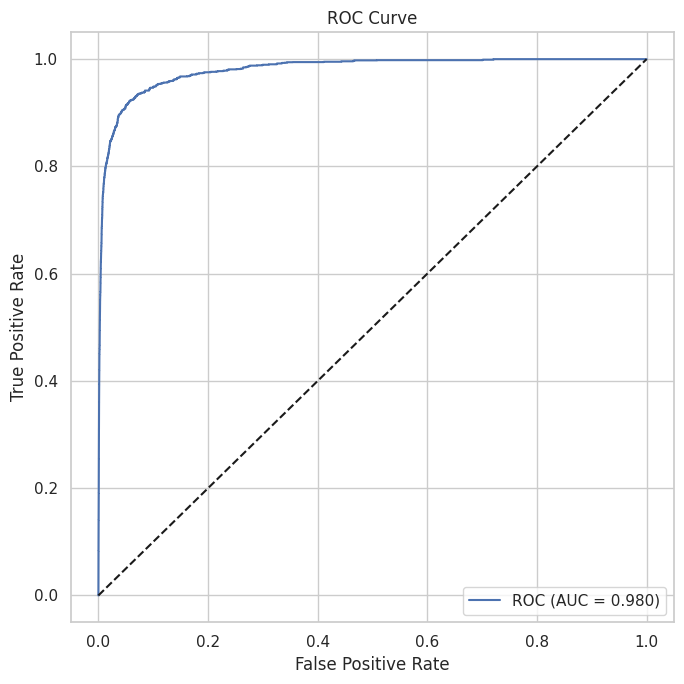

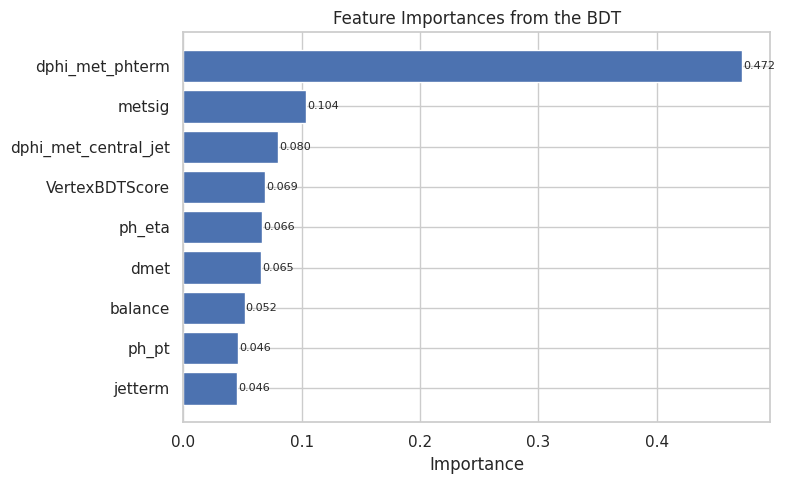

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

# plt.savefig("roc_randomsearch.png")
plt.show()

importances = model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(Vars_drop, axis=1).columns

plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(selected_columns)), importances[indices], align='center')

# Set y-ticks with feature names
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')

# Annotate each bar with the importance value
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=8)
plt.tight_layout()
# plt.savefig("feature_importance.png")
plt.show()

In [11]:
# save the dataframe to csv file
# df.to_csv("/data/jlai/ntups/bdt_output/bdt_0mu.csv", index=False)

# save the model
# model.save_model("/data/jlai/ntups/bdt_output/bdt_0mu_model.json")

In [7]:
def compute_significance(df, cut=0.5):
    s = df[(df["label"] == 1) & (df["MLBDTScore"] >= cut)]["weights"].sum()
    b = df[(df["label"] == 0) & (df["MLBDTScore"] >= cut)]["weights"].sum()
    return s / np.sqrt(b) if b > 0 else 0, s/df[(df['label'] == 1)]['weights'].sum()

max_sig, acceptance = max(compute_significance(df_output, cut) for cut in np.arange(0.0, 0.15, 0.01))
print(f"Max S/√B: {max_sig:.3f}, Acceptance: {acceptance*100} %")


Max S/√B: 3.364, Acceptance: 39.66407210465558 %


In [18]:
ntuple_names = np.unique(df_output['process'])
for i in range(len(ntuple_names)):
    process = ntuple_names[i]
    df_tmp = df_output[df_output.process == process]
    df_tmp = df_tmp.replace(np.nan, -999)
    df_tmp = df_tmp[df_tmp.MLBDTScore > 0.03]
    print(process, sum(df_tmp['weights']))

Wgamma 1229.3306238077896
Wjets 1043.0932798391664
Zgamma 620.0659641425243
Zjets 1.7932129578985037
data23 104.25924129232561
gammajet_direct 24.460201606363942
ggHyyd 198.86900221462167


Saved plot to significance_MLBDTScore_lowercut.png


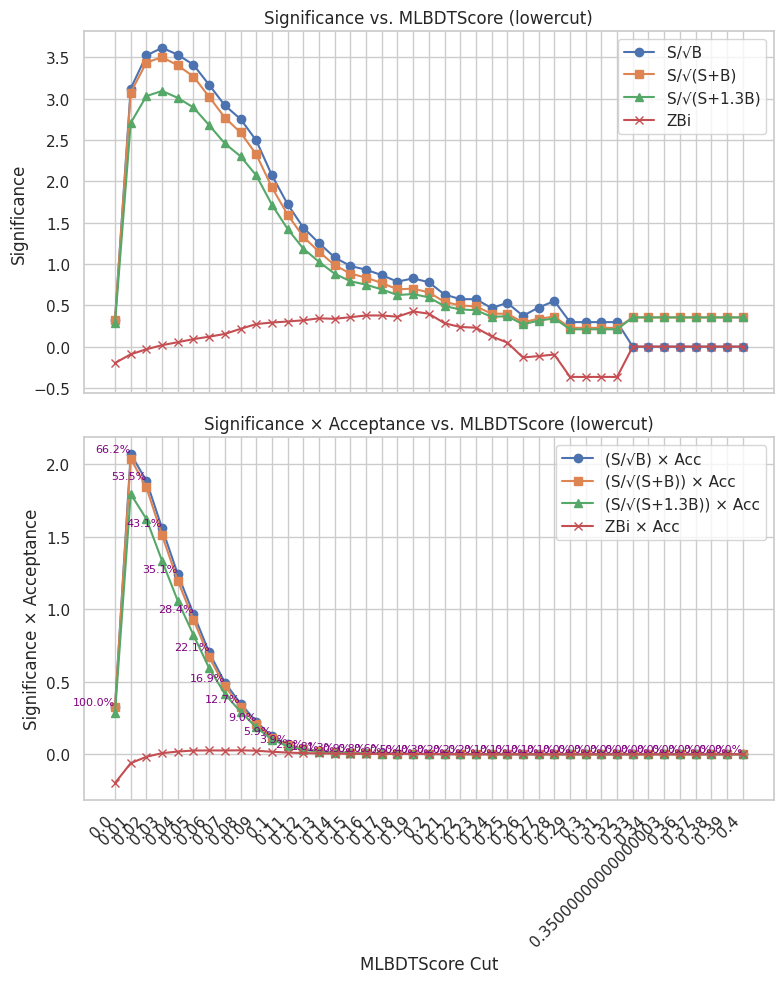

In [19]:
def binomial_significance(s, b):
    return s / np.sqrt(b) if b > 0 else 0

def s_over_sb(s, b):
    return s / np.sqrt(s + b) if (s + b) > 0 else 0

def s_over_s1p3b(s, b):
    return s / np.sqrt(s + 1.3 * b) if (s + 1.3 * b) > 0 else 0

def scan_significance(df, cut_var="MLBDTScore", cut_type="lowercut", cuts=np.arange(0, 0.71, 0.01)):
    sig_sqrtb = []
    sig_sqrt_sb = []
    sig_sqrt_s1p3b = []
    sig_zbi = []

    sigacc_sqrtb = []
    sigacc_sqrt_sb = []
    sigacc_sqrt_s1p3b = []
    sigacc_zbi = []

    acc_values = []

    df_sig = df[df["label"] == 1]
    df_bkg = df[df["label"] == 0]
    total_sig_weight = df_sig["weights"].sum()

    for cut in cuts:
        if cut_type == "lowercut":
            sig_cut = df_sig[df_sig[cut_var] >= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] >= cut]
        elif cut_type == "uppercut":
            sig_cut = df_sig[df_sig[cut_var] <= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] <= cut]
        else:
            raise ValueError("Invalid cut type")

        s = sig_cut["weights"].sum()
        b = bkg_cut["weights"].sum()
        acceptance = s / total_sig_weight if total_sig_weight > 0 else 0

        # Compute significance
        sig1 = binomial_significance(s, b)
        sig2 = s_over_sb(s, b)
        sig3 = s_over_s1p3b(s, b)
        sig4 = zbi(s, b)

        sig_sqrtb.append(sig1)
        sig_sqrt_sb.append(sig2)
        sig_sqrt_s1p3b.append(sig3)
        sig_zbi.append(sig4)

        sigacc_sqrtb.append(sig1 * acceptance)
        sigacc_sqrt_sb.append(sig2 * acceptance)
        sigacc_sqrt_s1p3b.append(sig3 * acceptance)
        sigacc_zbi.append(sig4 * acceptance)

        acc_values.append(acceptance * 100)

    return cuts, acc_values, sig_sqrtb, sig_sqrt_sb, sig_sqrt_s1p3b, sig_zbi, \
           sigacc_sqrtb, sigacc_sqrt_sb, sigacc_sqrt_s1p3b, sigacc_zbi


def plot_significance(cuts, acc, sig1, sig2, sig3, sig4,
                      sigacc1, sigacc2, sigacc3, sigacc4,
                      cut_var, cut_type, save_path):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    # Plot Significance
    ax1.plot(cuts, sig1, marker='o', label='S/√B')
    ax1.plot(cuts, sig2, marker='s', label='S/√(S+B)')
    ax1.plot(cuts, sig3, marker='^', label='S/√(S+1.3B)')
    ax1.plot(cuts, sig4, marker='x', label='ZBi')

    ax1.set_ylabel('Significance')
    ax1.set_title(f'Significance vs. {cut_var} ({cut_type})')
    ax1.grid(True)
    ax1.legend()

    # Plot Significance × Acceptance
    ax2.plot(cuts, sigacc1, marker='o', label='(S/√B) × Acc')
    ax2.plot(cuts, sigacc2, marker='s', label='(S/√(S+B)) × Acc')
    ax2.plot(cuts, sigacc3, marker='^', label='(S/√(S+1.3B)) × Acc')
    ax2.plot(cuts, sigacc4, marker='x', label='ZBi × Acc')

    for i, txt in enumerate(acc):
        ax2.text(cuts[i], sigacc1[i], f'{txt:.1f}%', fontsize=8, color='purple', ha='right', va='bottom')

    ax2.set_xlabel(f'{cut_var} Cut')
    ax2.set_ylabel('Significance × Acceptance')
    ax2.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xticks(cuts)
    ax2.set_xticklabels(cuts, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()


cut_var = "MLBDTScore"
cut_type = "lowercut"
cut_values = np.arange(0, 0.4 + 3e-12, 0.01)

(cuts, acc, sig1, sig2, sig3, sig4,
 sigacc1, sigacc2, sigacc3, sigacc4) = scan_significance(df_output, cut_var, cut_type, cut_values)

plot_significance(
    cuts, acc, sig1, sig2, sig3, sig4,
    sigacc1, sigacc2, sigacc3, sigacc4,
    cut_var=cut_var,
    cut_type=cut_type,
    save_path=f"significance_{cut_var}_{cut_type}.png"
)


In [8]:
df_output

,dphi_met_phterm,metsig,VertexBDTScore,dphi_met_central_jet,dmet,jetterm,balance,weights,label,process,ph_eta,ph_pt,MLBDTScore
0,0.938348,2.761993,0.131412,1.307934,0.000,84722.190,3.382770,0.074079,1,ggHyyd,1.116581,0.000015,0.000513
1,1.180506,8.542773,0.151073,2.712346,0.000,86744.400,1.784722,0.116076,1,ggHyyd,7.054524,0.000019,0.044589
2,1.881112,6.480173,0.326790,2.255124,0.000,186978.030,1.122666,0.119337,1,ggHyyd,0.618951,0.000008,0.014108
3,1.852292,5.958667,0.267467,2.601409,0.000,176778.980,0.756231,0.115276,1,ggHyyd,0.500710,0.000015,0.004003
4,0.323595,2.547094,0.189026,1.626958,0.000,49163.324,1.266329,0.119649,1,ggHyyd,0.438361,0.000011,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299728,0.086615,3.856843,0.021344,NaN,20045.516,58980.720,7.581804,11.211798,0,data23,0.901728,0.000014,0.000021
3299729,0.132232,2.750353,-0.046651,NaN,-23196.453,75701.836,4.419554,11.578539,0,data23,0.425681,0.000013,0.000003
3299730,0.190657,16.823483,0.218955,NaN,0.000,218678.190,2.965068,10.425924,0,data23,0.553796,0.000006,0.000003
3299731,0.179639,3.404925,-0.055574,2.473053,0.000,19826.225,4.414888,11.578539,0,data23,0.476878,0.000009,0.000011


In [37]:
df

,balance,VertexBDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,mt,weights,process,label,MLBDTScore
0,3.382770,0.131412,0.000,-999.000000,1.307934,0.938348,2.203245,0.664073,1.602420,2.772006,...,106920.875,171646.17,21859.162109,1942.6106,1,148.40038,0.074079,ggHyyd,1,2.276703e-04
1,1.784722,0.151073,0.000,-999.000000,2.712346,1.180506,1.961087,0.429247,1.609753,1.609753,...,102183.560,154814.61,-999.000000,12993.3780,1,121.85350,0.116076,ggHyyd,1,5.275241e-02
2,1.122666,0.326790,0.000,0.313718,2.255124,1.881112,1.260481,0.642131,2.523243,2.767581,...,113106.060,235372.84,-999.000000,4500.8604,3,138.60928,0.119337,ggHyyd,1,1.244310e-02
3,0.756231,0.267467,0.000,2.166679,2.601409,1.852292,1.289300,0.349927,2.202219,2.392476,...,131013.914,197134.22,33962.769531,16936.4980,3,111.85926,0.115276,ggHyyd,1,3.407549e-03
4,1.266329,0.189026,0.000,2.670413,1.626958,0.323595,2.817998,0.546473,0.870069,1.838230,...,125378.336,213597.25,-999.000000,2516.5588,2,207.59293,0.119649,ggHyyd,1,1.078138e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299728,7.581804,0.021344,20045.516,-999.000000,-999.000000,0.086615,3.054977,0.144932,0.231547,-999.000000,...,156691.400,207548.94,25537.773438,8009.5220,1,196.67690,11.211798,data23,0,7.327521e-06
3299729,4.419554,-0.046651,-23196.453,-999.000000,-999.000000,0.132232,3.009361,0.261050,0.393281,-999.000000,...,125404.670,225048.72,23714.308594,9464.1780,1,212.70273,11.578539,data23,0,7.437374e-07
3299730,2.965068,0.218955,0.000,-999.000000,-999.000000,0.190657,2.950936,0.153479,0.344136,-999.000000,...,388933.000,544819.90,-999.000000,20142.2170,1,490.22546,10.425924,data23,0,2.111725e-07
3299731,4.414888,-0.055574,0.000,2.633032,2.473053,0.179639,2.961954,2.039606,2.219245,0.488901,...,100550.080,209262.25,-999.000000,3081.4370,2,208.26012,11.578539,data23,0,5.023901e-06


In [12]:
print(len(df), len(df_ml_input))                         # must match
print((df.index == df_ml_input.index).all())             # should be True
print(df[['weights','label']].equals(df_output[['weights','label']]))
# Compare score alignment (only meaningful if indices match)
print(np.nanmax(np.abs(df['MLBDTScore'] - df_output['MLBDTScore'])))


3299733 3299733
True
False
0.0


In [13]:
for name, d in [('df', df), ('df_output', df_output)]:
    m = d['MLBDTScore'] >= 0.03
    S = d.loc[m & (d['label']==1), 'weights'].sum()
    B = d.loc[m & (d['label']==0), 'weights'].sum()
    print(name, 'S=', S, 'B=', B, 'S/sqrt(B)=', S/np.sqrt(B) if B>0 else 0)


df S= 183.2171527768392 B= 2249.0721449542984 S/sqrt(B)= 3.863353394922298
df_output S= 183.2171527768392 B= 2966.9085099428617 S/sqrt(B)= 3.363675196162161


In [11]:
df_tmp4 = df.copy()
df_tmp4 = df_tmp4[df_tmp4.MLBDTScore >= 0.03]
print(df_tmp4[df_tmp4.label == 1].weights.sum() / np.sqrt(df_tmp4[df_tmp4.label == 0].weights.sum()))


df_tmp4 = df_output.copy()
df_tmp4 = df_tmp4[df_tmp4.MLBDTScore >= 0.03]
print(df_tmp4[df_tmp4.label == 1].weights.sum() / np.sqrt(df_tmp4[df_tmp4.label == 0].weights.sum()))

3.863353394922298
3.363675196162161


In [ ]:
for 

In [32]:
df_output

,dphi_met_phterm,metsig,VertexBDTScore,dphi_met_central_jet,dmet,jetterm,balance,weights,label,process,ph_eta,ph_pt,MLBDTScore
0,0.938348,2.761993,0.131412,1.307934,0.000,84722.190,3.382770,0.074079,1,ggHyyd,1.116581,0.000015,2.276703e-04
1,1.180506,8.542773,0.151073,2.712346,0.000,86744.400,1.784722,0.116076,1,ggHyyd,7.054524,0.000019,5.275241e-02
2,1.881112,6.480173,0.326790,2.255124,0.000,186978.030,1.122666,0.119337,1,ggHyyd,0.618951,0.000008,1.244310e-02
3,1.852292,5.958667,0.267467,2.601409,0.000,176778.980,0.756231,0.115276,1,ggHyyd,0.500710,0.000015,3.407549e-03
4,0.323595,2.547094,0.189026,1.626958,0.000,49163.324,1.266329,0.119649,1,ggHyyd,0.438361,0.000011,1.078138e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299728,0.086615,3.856843,0.021344,NaN,20045.516,58980.720,7.581804,11.211798,0,data23,0.901728,0.000014,7.327521e-06
3299729,0.132232,2.750353,-0.046651,NaN,-23196.453,75701.836,4.419554,11.578539,0,data23,0.425681,0.000013,7.437374e-07
3299730,0.190657,16.823483,0.218955,NaN,0.000,218678.190,2.965068,10.425924,0,data23,0.553796,0.000006,2.111725e-07
3299731,0.179639,3.404925,-0.055574,2.473053,0.000,19826.225,4.414888,11.578539,0,data23,0.476878,0.000009,5.023901e-06


In [22]:
df.to_csv('/data/jlai/ntups/csv/bdt_output_reduced.csv', index=False)

In [23]:
df

,balance,VertexBDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,mt,weights,process,label,MLBDTScore
0,3.382770,0.131412,0.000,-999.000000,1.307934,0.938348,2.203245,0.664073,1.602420,2.772006,...,106920.875,171646.17,21859.162109,1942.6106,1,148.40038,0.074079,ggHyyd,1,2.276703e-04
1,1.784722,0.151073,0.000,-999.000000,2.712346,1.180506,1.961087,0.429247,1.609753,1.609753,...,102183.560,154814.61,-999.000000,12993.3780,1,121.85350,0.116076,ggHyyd,1,5.275241e-02
2,1.122666,0.326790,0.000,0.313718,2.255124,1.881112,1.260481,0.642131,2.523243,2.767581,...,113106.060,235372.84,-999.000000,4500.8604,3,138.60928,0.119337,ggHyyd,1,1.244310e-02
3,0.756231,0.267467,0.000,2.166679,2.601409,1.852292,1.289300,0.349927,2.202219,2.392476,...,131013.914,197134.22,33962.769531,16936.4980,3,111.85926,0.115276,ggHyyd,1,3.407549e-03
4,1.266329,0.189026,0.000,2.670413,1.626958,0.323595,2.817998,0.546473,0.870069,1.838230,...,125378.336,213597.25,-999.000000,2516.5588,2,207.59293,0.119649,ggHyyd,1,1.078138e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299728,7.581804,0.021344,20045.516,-999.000000,-999.000000,0.086615,3.054977,0.144932,0.231547,-999.000000,...,156691.400,207548.94,25537.773438,8009.5220,1,196.67690,11.211798,data23,0,7.327521e-06
3299729,4.419554,-0.046651,-23196.453,-999.000000,-999.000000,0.132232,3.009361,0.261050,0.393281,-999.000000,...,125404.670,225048.72,23714.308594,9464.1780,1,212.70273,11.578539,data23,0,7.437374e-07
3299730,2.965068,0.218955,0.000,-999.000000,-999.000000,0.190657,2.950936,0.153479,0.344136,-999.000000,...,388933.000,544819.90,-999.000000,20142.2170,1,490.22546,10.425924,data23,0,2.111725e-07
3299731,4.414888,-0.055574,0.000,2.633032,2.473053,0.179639,2.961954,2.039606,2.219245,0.488901,...,100550.080,209262.25,-999.000000,3081.4370,2,208.26012,11.578539,data23,0,5.023901e-06
